In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, roc_auc_score, recall_score, roc_curve, precision_recall_curve
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.offline as py

In [131]:
circuits = pd.read_csv('circuits.csv')
constructor_results = pd.read_csv('constructor_results.csv')
constructors_standings = pd.read_csv('constructor_standings.csv')
constructors = pd.read_csv('constructors.csv')
drivers_standings = pd.read_csv('driver_standings.csv')
drivers = pd.read_csv('drivers.csv')
lap_times = pd.read_csv('lap_times.csv')
pit_stops = pd.read_csv('pit_stops.csv')
qualifying = pd.read_csv('qualifying.csv')
races = pd.read_csv('races.csv')
results = pd.read_csv('results.csv')
seasons = pd.read_csv('seasons.csv')
status = pd.read_csv('status.csv')

In [132]:
def getMiliSeconds(time):
    try:
        if '.' in time:
            x = datetime.datetime.strptime(time,'%M:%S.%f')
        elif ',' in time:
            x = datetime.datetime.strptime(time,'%M:%S,%f')
        else:
            x = datetime.datetime.strptime(time,'%M:%S:%f')
        return datetime.timedelta(minutes=x.minute,seconds=x.second, microseconds = x.microsecond).total_seconds()
    except:
        x = datetime.datetime.strptime(str(time).split('.')[0],'%M:%S:%f')
        return datetime.timedelta(minutes=x.minute,seconds=x.second, microseconds = x.microsecond).total_seconds()

results['fastestLapTime'] = results['fastestLapTime'].replace('0','00:00.0')
qualifying['q1'] = qualifying['q1'].replace('0','00:00.0')
qualifying['q2'] = qualifying['q2'].replace('0','00:00.0')
qualifying['q3'] = qualifying['q3'].replace('0','00:00.0')

qualifying['q1'] = qualifying['q1'].apply(lambda x: getMiliSeconds(x))
qualifying['q2'] = qualifying['q2'].apply(lambda x: getMiliSeconds(x))
qualifying['q3'] = qualifying['q3'].apply(lambda x: getMiliSeconds(x))
lap_times['time'] = lap_times['time'].apply(lambda x: getMiliSeconds(x))
results['fastestLapTime'] = results['fastestLapTime'].apply(lambda x: getMiliSeconds(x))

drivers['fullName'] = drivers['forename'] +" "+ drivers['surname']



In [133]:
qualifying = qualifying.drop(['constructorId'], axis = 1)
qualifying = qualifying.drop(['number'], axis = 1)
qualifying = qualifying.drop(['position'], axis = 1)

In [134]:
data = pd.merge(results, qualifying, on=['raceId', 'driverId'], how='left')
pd.set_option('display.max_columns', 500)
data.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,qualifyId,q1,q2,q3
0,1,18,1,1,22,1,1,1,1,10.0,58,34:50.6,5690616,39,2,87.5,218.300,1,1.0,86.6,85.2,86.7
1,2,18,2,2,3,5,2,2,2,8.0,58,5.478,5696094,41,3,87.7,217.586,1,5.0,86.0,85.5,87.2
2,3,18,3,3,7,7,3,3,3,6.0,58,8.163,5698779,41,5,88.1,216.719,1,7.0,86.3,86.1,88.7
3,4,18,4,4,5,11,4,4,4,5.0,58,17.181,5707797,58,7,88.6,215.464,1,12.0,86.9,86.2,0.0
4,5,18,5,1,23,3,5,5,5,4.0,58,18.014,5708630,43,1,87.4,218.385,1,3.0,85.7,85.5,87.1


In [135]:
data = pd.merge(data, races, on='raceId', how='left')
data.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time_x,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,qualifyId,q1,q2,q3,year,round,circuitId,name,date,time_y,url
0,1,18,1,1,22,1,1,1,1,10.0,58,34:50.6,5690616,39,2,87.5,218.300,1,1.0,86.6,85.2,86.7,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...
1,2,18,2,2,3,5,2,2,2,8.0,58,5.478,5696094,41,3,87.7,217.586,1,5.0,86.0,85.5,87.2,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...
2,3,18,3,3,7,7,3,3,3,6.0,58,8.163,5698779,41,5,88.1,216.719,1,7.0,86.3,86.1,88.7,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...
3,4,18,4,4,5,11,4,4,4,5.0,58,17.181,5707797,58,7,88.6,215.464,1,12.0,86.9,86.2,0.0,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...
4,5,18,5,1,23,3,5,5,5,4.0,58,18.014,5708630,43,1,87.4,218.385,1,3.0,85.7,85.5,87.1,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,http://en.wikipedia.org/wiki/2008_Australian_G...


In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24880 entries, 0 to 24879
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         24880 non-null  int64  
 1   raceId           24880 non-null  int64  
 2   driverId         24880 non-null  int64  
 3   constructorId    24880 non-null  int64  
 4   number           24880 non-null  int64  
 5   grid             24880 non-null  int64  
 6   position         24880 non-null  int64  
 7   positionText     24880 non-null  object 
 8   positionOrder    24880 non-null  int64  
 9   points           24880 non-null  float64
 10  laps             24880 non-null  int64  
 11  time_x           24880 non-null  object 
 12  milliseconds     24880 non-null  int64  
 13  fastestLap       24880 non-null  int64  
 14  rank             24880 non-null  int64  
 15  fastestLapTime   24880 non-null  float64
 16  fastestLapSpeed  24880 non-null  float64
 17  statusId    

In [137]:
data = data.drop(['positionText'], axis = 1)
data = data.drop(['time_x'], axis = 1)
data = data.drop(['name'], axis = 1)
data = data.drop(['date'], axis = 1)
data = data.drop(['time_y'], axis = 1)
data = data.drop(['url'], axis = 1)
data = data.drop(['milliseconds'], axis = 1)

In [138]:
data.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionOrder,points,laps,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,qualifyId,q1,q2,q3,year,round,circuitId
0,1,18,1,1,22,1,1,1,10.0,58,39,2,87.5,218.300,1,1.0,86.6,85.2,86.7,2008,1,1
1,2,18,2,2,3,5,2,2,8.0,58,41,3,87.7,217.586,1,5.0,86.0,85.5,87.2,2008,1,1
2,3,18,3,3,7,7,3,3,6.0,58,41,5,88.1,216.719,1,7.0,86.3,86.1,88.7,2008,1,1
3,4,18,4,4,5,11,4,4,5.0,58,58,7,88.6,215.464,1,12.0,86.9,86.2,0.0,2008,1,1
4,5,18,5,1,23,3,5,5,4.0,58,43,1,87.4,218.385,1,3.0,85.7,85.5,87.1,2008,1,1


In [139]:
data.isnull().sum()

resultId               0
raceId                 0
driverId               0
constructorId          0
number                 0
grid                   0
position               0
positionOrder          0
points                 0
laps                   0
fastestLap             0
rank                   0
fastestLapTime         0
fastestLapSpeed        0
statusId               0
qualifyId          16266
q1                 16266
q2                 16266
q3                 16266
year                   0
round                  0
circuitId              0
dtype: int64

In [140]:
data = data.replace(np.nan, 0)

In [141]:
data['podium'] = 0

In [142]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24880 entries, 0 to 24879
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         24880 non-null  int64  
 1   raceId           24880 non-null  int64  
 2   driverId         24880 non-null  int64  
 3   constructorId    24880 non-null  int64  
 4   number           24880 non-null  int64  
 5   grid             24880 non-null  int64  
 6   position         24880 non-null  int64  
 7   positionOrder    24880 non-null  int64  
 8   points           24880 non-null  float64
 9   laps             24880 non-null  int64  
 10  fastestLap       24880 non-null  int64  
 11  rank             24880 non-null  int64  
 12  fastestLapTime   24880 non-null  float64
 13  fastestLapSpeed  24880 non-null  float64
 14  statusId         24880 non-null  int64  
 15  qualifyId        24880 non-null  float64
 16  q1               24880 non-null  float64
 17  q2          

In [143]:
podium = []

for x in data['position']:
    if x == 1:
        podium.append(1)
    elif x == 2:
        podium.append(1)
    elif x == 3:
        podium.append(1)
    else:
        podium.append(0)

In [144]:
data['podium'] = podium

In [145]:
data = data.sort_values(['year','round'])

In [146]:
data.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionOrder,points,laps,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,qualifyId,q1,q2,q3,year,round,circuitId,podium
20024,20025,833,642,51,2,1,1,1,9.0,70,0,0,0.0,0.0,1,0.0,0.0,0.0,0.0,1950,1,9,1
20025,20026,833,786,51,3,2,2,2,6.0,70,0,0,0.0,0.0,1,0.0,0.0,0.0,0.0,1950,1,9,1
20026,20027,833,686,51,4,4,3,3,4.0,70,0,0,0.0,0.0,1,0.0,0.0,0.0,0.0,1950,1,9,1
20027,20028,833,704,154,14,6,4,4,3.0,68,0,0,0.0,0.0,12,0.0,0.0,0.0,0.0,1950,1,9,0
20028,20029,833,627,154,15,9,5,5,2.0,68,0,0,0.0,0.0,12,0.0,0.0,0.0,0.0,1950,1,9,0


In [147]:
data.tail()

,resultId,raceId,driverId,constructorId,number,grid,position,positionOrder,points,laps,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,qualifyId,q1,q2,q3,year,round,circuitId,podium
24875,24881,1043,847,3,63,13,0,16,0.0,51,43,16,78.8,224.237,3,8647.0,75.8,75.3,0.0,2020,13,21,0
24876,24882,1043,830,9,33,3,0,17,0.0,50,44,5,77.6,227.628,29,8637.0,75.0,75.0,74.2,2020,13,21,0
24877,24883,1043,825,210,20,17,0,18,0.0,47,45,18,79.3,222.930,139,8651.0,75.9,0.0,0.0,2020,13,21,0
24878,24884,1043,839,4,31,12,0,19,0.0,27,22,19,79.6,221.998,6,8646.0,75.4,75.2,0.0,2020,13,21,0
24879,24885,1043,842,213,10,4,0,20,0.0,8,5,20,80.4,219.797,34,8638.0,75.2,74.7,74.5,2020,13,21,0


In [148]:
data = data.drop(['position'], axis = 1)
data = data.drop(['positionOrder'], axis = 1)
data = data.drop(['qualifyId'], axis = 1)
data = data.drop(['resultId'], axis = 1)
data = data.drop(['points'], axis = 1)

In [149]:
data.head()

,raceId,driverId,constructorId,number,grid,laps,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,q1,q2,q3,year,round,circuitId,podium
20024,833,642,51,2,1,70,0,0,0.0,0.0,1,0.0,0.0,0.0,1950,1,9,1
20025,833,786,51,3,2,70,0,0,0.0,0.0,1,0.0,0.0,0.0,1950,1,9,1
20026,833,686,51,4,4,70,0,0,0.0,0.0,1,0.0,0.0,0.0,1950,1,9,1
20027,833,704,154,14,6,68,0,0,0.0,0.0,12,0.0,0.0,0.0,1950,1,9,0
20028,833,627,154,15,9,68,0,0,0.0,0.0,12,0.0,0.0,0.0,1950,1,9,0


<AxesSubplot:>

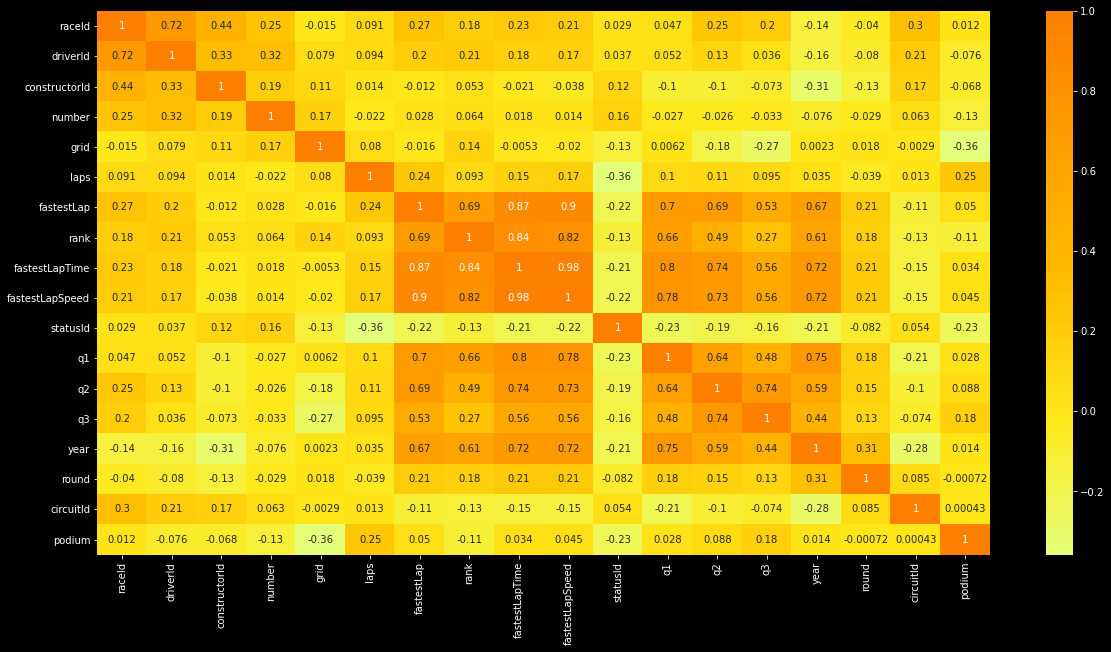

In [150]:
corrplot = data.corr()
plt.style.use("dark_background")
plt.figure(figsize=(20,10))
sns.heatmap(corrplot, cmap="Wistia", annot = True)

In [151]:
train = data[data['year']<2020]
test = data[data['year']>2019]

In [152]:
train.tail()

,raceId,driverId,constructorId,number,grid,laps,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,q1,q2,q3,year,round,circuitId,podium
24616,1030,841,51,99,16,54,28,15,103.3,193.639,11,98.1,0.0,0.0,2019,21,24,0
24617,1030,847,3,63,18,54,50,13,103.1,193.981,11,98.7,0.0,0.0,2019,21,24,0
24618,1030,842,5,10,11,53,53,10,102.4,195.231,12,97.2,97.1,0.0,2019,21,24,0
24619,1030,9,3,88,19,53,51,20,104.5,191.333,12,99.2,0.0,0.0,2019,21,24,0
24620,1030,840,211,18,12,45,25,17,103.3,193.507,23,97.5,97.1,0.0,2019,21,24,0


In [153]:
test.head()

,raceId,driverId,constructorId,number,grid,laps,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,q1,q2,q3,year,round,circuitId,podium
24560,1031,822,131,77,1,71,68,2,67.7,229.758,1,64.1,63.0,62.9,2020,1,70,1
24621,1031,844,6,16,7,71,64,4,67.9,228.933,1,64.5,64.0,63.9,2020,1,70,1
24622,1031,846,1,4,3,71,71,1,67.5,230.378,1,64.6,63.8,63.6,2020,1,70,1
24623,1031,1,131,44,5,71,67,3,67.7,229.572,1,64.2,63.1,63.0,2020,1,70,0
24624,1031,832,1,55,8,71,63,5,68.0,228.687,1,64.5,64.0,64.0,2020,1,70,0


In [154]:
x_train = train.drop(['podium'], axis = 1)
y_train = train['podium']

In [155]:
x_test = test.drop(['podium'], axis = 1)
y_test = test['podium']

In [156]:
xgb_model = xgb.XGBClassifier(n_estimators=50, objective='binary:logistic', random_state=0, seed = None, silent = True, subsample = 0.6)
xgb_model.fit(x_train, y_train)

[16:50:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=True, subsample=0.6, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [157]:
y_pred = xgb_model.predict(x_test)

In [158]:
print('Model Accuracy is {}'.format(accuracy_score(y_test, y_pred)*1e2))

Model Accuracy is 93.84615384615384


In [159]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       221
           1       0.85      0.72      0.78        39

    accuracy                           0.94       260
   macro avg       0.90      0.85      0.87       260
weighted avg       0.94      0.94      0.94       260



In [160]:
y_score = xgb_model.predict_proba(x_test)[:,1]

In [161]:
def model_performance_plot(model) : 
    #conf matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #plot roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_score) , 3)
    fpr, tpr, t = roc_curve(y_test, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : ",
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, print_grid=False, 
                        subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance</b><br>'+str(model),
                        autosize = False, height = 900,width = 830,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
    fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05])
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05])
    fig.layout.titlefont.size = 14
    
    py.iplot(fig)

In [162]:
model_performance_plot(xgb_model)

D:\Programs\Anaconda\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [163]:
x_test['driverId'] = x_test['driverId'].replace(1,'Ham')
x_test['driverId'] = x_test['driverId'].replace(822,'Bot')
x_test['driverId'] = x_test['driverId'].replace(20,'Vet')
x_test['driverId'] = x_test['driverId'].replace(844,'Lec')
x_test['driverId'] = x_test['driverId'].replace(830,'Ver')
x_test['driverId'] = x_test['driverId'].replace(848,'Alb')
x_test['driverId'] = x_test['driverId'].replace(846,'Nor')
x_test['driverId'] = x_test['driverId'].replace(832,'Sai')
x_test['driverId'] = x_test['driverId'].replace(817,'Ric')
x_test['driverId'] = x_test['driverId'].replace(839,'Oco')
x_test['driverId'] = x_test['driverId'].replace(842,'Gas')
x_test['driverId'] = x_test['driverId'].replace(826,'Kyv')
x_test['driverId'] = x_test['driverId'].replace(815,'Per')
x_test['driverId'] = x_test['driverId'].replace(840,'Str')
x_test['driverId'] = x_test['driverId'].replace(8,'Rai')
x_test['driverId'] = x_test['driverId'].replace(841,'Gio')
x_test['driverId'] = x_test['driverId'].replace(825,'Mag')
x_test['driverId'] = x_test['driverId'].replace(154,'Gro')
x_test['driverId'] = x_test['driverId'].replace(849,'Lat')
x_test['driverId'] = x_test['driverId'].replace(847,'Rus')

In [164]:
confusion_matrix(y_test, y_pred)

array([[216,   5],
       [ 11,  28]], dtype=int64)

<AxesSubplot:>

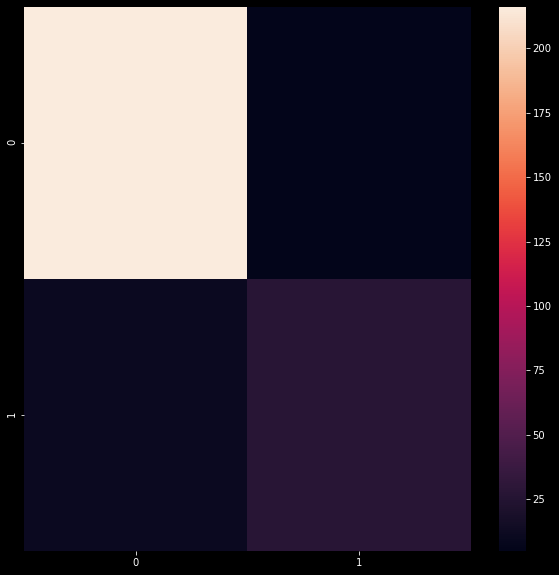

In [165]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(y_test, y_pred))

In [166]:
x_test['y_pred'] = y_pred
x_test['y_actual'] = y_test

In [167]:
pd.set_option('display.max_rows', 500)
x_test.tail(20)

,raceId,driverId,constructorId,number,grid,laps,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,q1,q2,q3,year,round,circuitId,y_pred,y_actual
24860,1043,Ham,131,44,2,63,63,1,75.5,234.121,1,74.2,74.6,73.7,2020,13,21,1,1
24861,1043,Bot,131,77,1,63,63,2,75.9,232.831,1,74.2,74.6,73.6,2020,13,21,1,1
24862,1043,Ric,4,3,5,63,62,4,77.6,227.878,1,75.5,75.0,74.5,2020,13,21,0,1
24863,1043,Kyv,213,26,8,63,62,6,77.7,227.543,1,75.4,75.0,74.7,2020,13,21,0,0
24864,1043,Lec,6,16,7,63,62,12,78.2,226.067,1,75.1,75.0,74.6,2020,13,21,0,0
24865,1043,Per,211,11,11,63,49,9,78.1,226.325,1,75.4,75.1,0.0,2020,13,21,0,0
24866,1043,Sai,1,55,10,63,62,11,78.1,226.226,1,75.5,75.0,74.9,2020,13,21,0,0
24867,1043,Nor,1,4,9,63,63,8,78.1,226.368,1,75.3,75.1,74.8,2020,13,21,0,0
24868,1043,Rai,51,7,18,63,63,10,78.1,226.313,1,76.0,0.0,0.0,2020,13,21,0,0
24869,1043,Gio,51,99,20,63,61,15,78.8,224.286,1,76.2,0.0,0.0,2020,13,21,0,0


D:\Programs\Anaconda\lib\site-packages\seaborn\categorical.py:3695: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



<Figure size 1080x576 with 0 Axes>

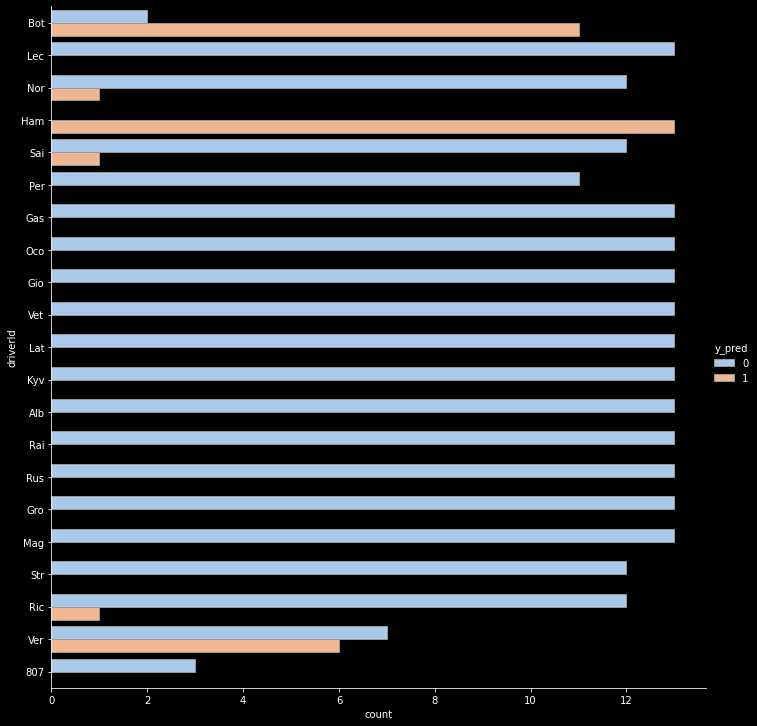

In [168]:
plt.figure(figsize=(15,8))
sns.catplot(y="driverId", hue="y_pred", kind="count",
            palette="pastel", edgecolor=".6",
            data=x_test, size = 10)

In [172]:
# data.to_csv('data.csv', index=False)

In [173]:
real_data = pd.read_csv('data.csv')

real_train = real_data[real_data['raceId']<=1043]
real_test = real_data[real_data['raceId']==1044]


real_x_train = real_train.drop(['podium'], axis = 1)
real_y_train = real_train['podium']

real_x_test = real_test.drop(['podium'], axis = 1)
real_x_test = real_x_test.sort_values('grid')
real_x_test.to_csv('test.csv', index=False)

real_xgb_model = xgb.XGBClassifier(n_estimators=500, objective='binary:logistic', random_state=0, seed = None, silent = True, subsample = 0.6)
real_xgb_model.fit(real_x_train, real_y_train)

[16:53:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=True, subsample=0.6, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [174]:
real_x_test = pd.read_csv('test.csv')
real_x_test = real_x_test.sort_values('grid')
real_x_test.to_csv('test2.csv', index=False)
real_y_pred = xgb_model.predict(real_x_test)
real_x_test['real_y_pred'] = real_y_pred
real_x_test

,raceId,driverId,constructorId,number,grid,laps,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,q1,q2,q3,year,round,circuitId,real_y_pred
0,1044,840,211,18,1,58,0,13,0.0,0.0,1,127.47,113.37,107.77,2020,14,5,0
1,1044,830,9,33,2,58,0,5,0.0,0.0,1,117.49,110.29,108.06,2020,14,5,1
2,1044,815,211,11,3,58,0,9,0.0,0.0,1,127.61,114.10,109.32,2020,14,5,0
3,1044,848,9,23,4,58,0,3,0.0,0.0,1,119.43,112.28,110.45,2020,14,5,0
4,1044,817,4,3,5,58,0,4,0.0,0.0,1,125.60,114.28,111.60,2020,14,5,0
5,1044,1,131,44,6,58,0,1,0.0,0.0,1,127.60,112.71,112.56,2020,14,5,1
6,1044,839,4,31,7,58,0,19,0.0,0.0,1,126.12,113.66,112.62,2020,14,5,0
7,1044,8,51,7,8,58,0,10,0.0,0.0,1,121.25,113.79,112.75,2020,14,5,0
8,1044,822,131,77,9,58,0,2,0.0,0.0,1,127.00,113.77,113.26,2020,14,5,0
9,1044,841,51,99,10,16,0,15,0.0,0.0,1,127.34,113.43,117.23,2020,14,5,0


In [178]:
real_x_test['driverId'] = real_x_test['driverId'].replace(1,'Ham')
real_x_test['driverId'] = real_x_test['driverId'].replace(822,'Bot')
real_x_test['driverId'] = real_x_test['driverId'].replace(20,'Vet')
real_x_test['driverId'] = real_x_test['driverId'].replace(844,'Lec')
real_x_test['driverId'] = real_x_test['driverId'].replace(830,'Ver')
real_x_test['driverId'] = real_x_test['driverId'].replace(848,'Alb')
real_x_test['driverId'] = real_x_test['driverId'].replace(846,'Nor')
real_x_test['driverId'] = real_x_test['driverId'].replace(832,'Sai')
real_x_test['driverId'] = real_x_test['driverId'].replace(817,'Ric')
real_x_test['driverId'] = real_x_test['driverId'].replace(839,'Oco')
real_x_test['driverId'] = real_x_test['driverId'].replace(842,'Gas')
real_x_test['driverId'] = real_x_test['driverId'].replace(826,'Kyv')
real_x_test['driverId'] = real_x_test['driverId'].replace(815,'Per')
real_x_test['driverId'] = real_x_test['driverId'].replace(840,'Str')
real_x_test['driverId'] = real_x_test['driverId'].replace(8,'Rai')
real_x_test['driverId'] = real_x_test['driverId'].replace(841,'Gio')
real_x_test['driverId'] = real_x_test['driverId'].replace(825,'Mag')
real_x_test['driverId'] = real_x_test['driverId'].replace(154,'Gro')
real_x_test['driverId'] = real_x_test['driverId'].replace(849,'Lat')
real_x_test['driverId'] = real_x_test['driverId'].replace(847,'Rus')

real_x_test.to_csv('test3.csv', index=False)
real_x_test

,raceId,driverId,constructorId,number,grid,laps,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,q1,q2,q3,year,round,circuitId,real_y_pred
0,1044,Str,211,18,1,58,0,13,0.0,0.0,1,127.47,113.37,107.77,2020,14,5,0
1,1044,Ver,9,33,2,58,0,5,0.0,0.0,1,117.49,110.29,108.06,2020,14,5,1
2,1044,Per,211,11,3,58,0,9,0.0,0.0,1,127.61,114.10,109.32,2020,14,5,0
3,1044,Alb,9,23,4,58,0,3,0.0,0.0,1,119.43,112.28,110.45,2020,14,5,0
4,1044,Ric,4,3,5,58,0,4,0.0,0.0,1,125.60,114.28,111.60,2020,14,5,0
5,1044,Ham,131,44,6,58,0,1,0.0,0.0,1,127.60,112.71,112.56,2020,14,5,1
6,1044,Oco,4,31,7,58,0,19,0.0,0.0,1,126.12,113.66,112.62,2020,14,5,0
7,1044,Rai,51,7,8,58,0,10,0.0,0.0,1,121.25,113.79,112.75,2020,14,5,0
8,1044,Bot,131,77,9,58,0,2,0.0,0.0,1,127.00,113.77,113.26,2020,14,5,0
9,1044,Gio,51,99,10,16,0,15,0.0,0.0,1,127.34,113.43,117.23,2020,14,5,0
